In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from maneuvers import Maneuvers
import models
from constants import constants
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
rp = 7000e3
ra = 7010e3
Omega = 340*np.pi/180
i = 65.1*np.pi/180
omega = 58*np.pi/180
nu = 332*np.pi/180
a = (rp+ra)/2
e = ra/a-1
coe = [a,e,i,omega,Omega,nu]

# Dates
startTime = "24 Feb 2012 16:00:00.000"
startDate = datetime.strptime(startTime,"%d %b %Y %H:%M:%S.000")
IdleTime = 60*60
ThrustingTime = 60*60*24*146
Idle2Time = 60*60*24*30*2
stopDate = startDate + timedelta(seconds=IdleTime+ThrustingTime+Idle2Time)
stopTime = str(stopDate.strftime("%d %b %Y %H:%M:%S.000"))
# Spacecraft
wetMass = 3
propMass = 2.9
area = 10
satellite = models.Spacecraft(wetMass,wetMass-propMass,area)

# Thruster
thrust = 1e-3
isp = 720
satellite.thruster = models.Thruster(thrust=thrust,isp=isp)

# Maneuvers
maneuver = Maneuvers(coe,satellite,startDate,formulation="betts")
maneuver.propagate(IdleTime,60);
maneuver.addPerturbation("thrust")
maneuver.propagate(ThrustingTime/3,60);
maneuver.propagate(ThrustingTime/3,60*10);
maneuver.propagate(ThrustingTime/3,60*60);
maneuver.removePerturbation("thrust")
maneuver.propagate(Idle2Time,60*60);

Propagating...from day  0.0  to  0.041666666666666664
Propagating...from day  0.041666666666666664  to  48.708333333333336
Propagating...from day  48.708333333333336  to  97.375
Propagating...from day  97.375  to  146.04166666666666
Propagating...from day  146.04166666666666  to  206.04166666666666


In [42]:
matlabCode = "\
try\n\
    componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');\n\
catch\n\
    app = actxserver('STK11.application');\n\
    app.UserControl = 1;\n\
    app.visible = 1;\n\
    root = app.Personality2;\n\
    root.NewScenario('Validation');\n\
    scenario = root.CurrentScenario;\n\
\n\
    scenario.SetTimePeriod('"+startTime+"','"+stopTime+"');\n\
    scenario.StartTime = '"+startTime+"';\n\
    scenario.StopTime = '"+stopTime+"';\n\
\n\
    root.ExecuteCommand('Animate * Reset');\n\
    %% Satellite Definition and Astrogator Init\n\
    try\n\
        scenario.Children.Unload('eSatellite','ValidationSat');\n\
    catch\n\
    end\n\
    satellite = scenario.Children.New('eSatellite','ValidationSat');\n\
    satellite.SetPropagatorType('ePropagatorAstrogator');\n\
    ASTG = satellite.Propagator;\n\
    MCS = ASTG.MainSequence;\n\
end\n\
%% Astrogator Config\n\
componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');\n\
engineModels = componentAstrogator.GetFolder('Engine Models');\n\
try\n\
    customThruster = engineModels.Item('customThruster');\n\
catch\n\
    customThruster = engineModels.DuplicateComponent('Constant Thrust and Isp','customThruster');\n\
end\n\
customThruster.Isp = "+str(isp)+";\n\
customThruster.Thrust = "+str(thrust)+";\n\
\n\
MCS.RemoveAll;\n\
\n\
initstate = MCS.Insert('eVASegmentTypeInitialState','Inner Orbit','-');\n\
initstate.OrbitEpoch = scenario.StartTime;\n\
initstate.SetElementType('eVAElementTypeModKeplerian');\n\
\n\
initstate.InitialState.DryMass = "+str(wetMass-propMass)+";\n\
initstate.InitialState.Cd = 2.2;\n\
initstate.InitialState.DragArea = "+str(area)+";\n\
initstate.InitialState.Cr = 1;\n\
initstate.InitialState.SRPArea = 20;\n\
\n\
initstate.FuelTank.FuelMass = "+str(propMass)+";\n\
\n\
initstate.Element.RadiusOfPeriapsis = "+str(rp/1e3)+";\n\
initstate.Element.Eccentricity = "+str(e)+";\n\
initstate.Element.Inclination = "+str(i*180/np.pi)+";\n\
initstate.Element.RAAN = "+str(Omega*180/np.pi)+";\n\
initstate.Element.ArgOfPeriapsis = "+str(omega*180/np.pi)+";\n\
initstate.Element.TrueAnomaly = "+str(nu*180/np.pi)+";\n\
\n\
propagate = MCS.Insert('eVASegmentTypePropagate','Propagate','-');\n\
propagate.PropagatorName = 'Earth Point Mass';\n\
propagate.Properties.Color = uint32(hex2dec('00ff00'));\n\
propagate.StoppingConditions.Item('Duration').Properties.Trip = "+str(IdleTime)+";\n\
\n\
dv1 = MCS.Insert('eVASegmentTypeManeuver','DV1','-');\n\
dv1.Properties.Color = uint32(hex2dec('00d3ff'));\n\
dv1.SetManeuverType('eVAManeuverTypeFinite');\n\
\n\
maneuver = dv1.Maneuver;\n\
maneuver.SetAttitudeControlType('eVAAttitudeControlThrustVector');\n\
maneuver.AttitudeControl.ThrustAxesName = 'Satellite VNC(Earth)';\n\
maneuver.AttitudeControl.ThrustVector.AssignXYZ(1,0,0);\n\
maneuver.Propagator.StoppingConditions.Item('Duration').Properties.Trip = "+str(ThrustingTime)+";\n\
maneuver.Propagator.PropagatorName = 'Earth Point Mass';\n\
maneuver.SetPropulsionMethod('eVAPropulsionMethodEngineModel','customThruster');\n\
\n\
propagate2 = MCS.Insert('eVASegmentTypePropagate','Propagate','-');\n\
propagate2.PropagatorName = 'Earth Point Mass';\n\
propagate2.Properties.Color = uint32(hex2dec('00ff00'));\n\
propagate2.StoppingConditions.Item('Duration').Properties.Trip = "+str(Idle2Time)+";\n\
\n\
ASTG.RunMCS;\n\
\n\
keplerianElemsDP = satellite.DataProviders.Item('Astrogator Values').Group.Item('Keplerian Elems').Exec(scenario.StartTime, scenario.StopTime,60);\n\
maneuverDP = satellite.DataProviders.Item('Astrogator Values').Group.Item('Maneuver').Exec(scenario.StartTime, scenario.StopTime,60);\n\
keplerianElemsData = keplerianElemsDP.DataSets.ToArray;\n\
maneuverData = maneuverDP.DataSets.ToArray;\n\
maneuverData = maneuverData(:,2:end);\n\
table = cell2table([keplerianElemsData,maneuverData],'VariableNames',[keplerianElemsDP.DataSets.ElementNames;maneuverDP.DataSets.ElementNames(2:end)]);\n\
writetable(table,'dataOut.csv');\n\
\n\
exit;";
print(matlabCode)

with open("./validation/matlabSTK.m", "w") as file:
    file.write(matlabCode)
os.system('matlab -nosplash -nodesktop -wait -r "run(\'validation/matlabSTK.m\')"')
data = {}
with open('./validation/dataOut.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    csv_list = list(csv_reader)
    for key in csv_list[0]:
        print(key)
        data[key] = np.array([])
    
    for Idx,row in enumerate(csv_list):
        for key in row:
            if key == "Time":
                data[key] = np.append(data[key],datetime.strptime(row[key], '%d %b %Y %H:%M:%S.000000000'))
            else:
                data[key] = np.append(data[key],float(row[key]))

try
    componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');
catch
    app = actxserver('STK11.application');
    app.UserControl = 1;
    app.visible = 1;
    root = app.Personality2;
    root.NewScenario('Validation');
    scenario = root.CurrentScenario;

    scenario.SetTimePeriod('24 Feb 2012 16:00:00.000','05 Mar 2012 18:00:00.000');
    scenario.StartTime = '24 Feb 2012 16:00:00.000';
    scenario.StopTime = '05 Mar 2012 18:00:00.000';

    root.ExecuteCommand('Animate * Reset');
    %% Satellite Definition and Astrogator Init
    try
        scenario.Children.Unload('eSatellite','ValidationSat');
    catch
    end
    satellite = scenario.Children.New('eSatellite','ValidationSat');
    satellite.SetPropagatorType('ePropagatorAstrogator');
    ASTG = satellite.Propagator;
    MCS = ASTG.MainSequence;
end
%% Astrogator Config
componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');
engineModels = componentAstroga

<IPython.core.display.Javascript object>


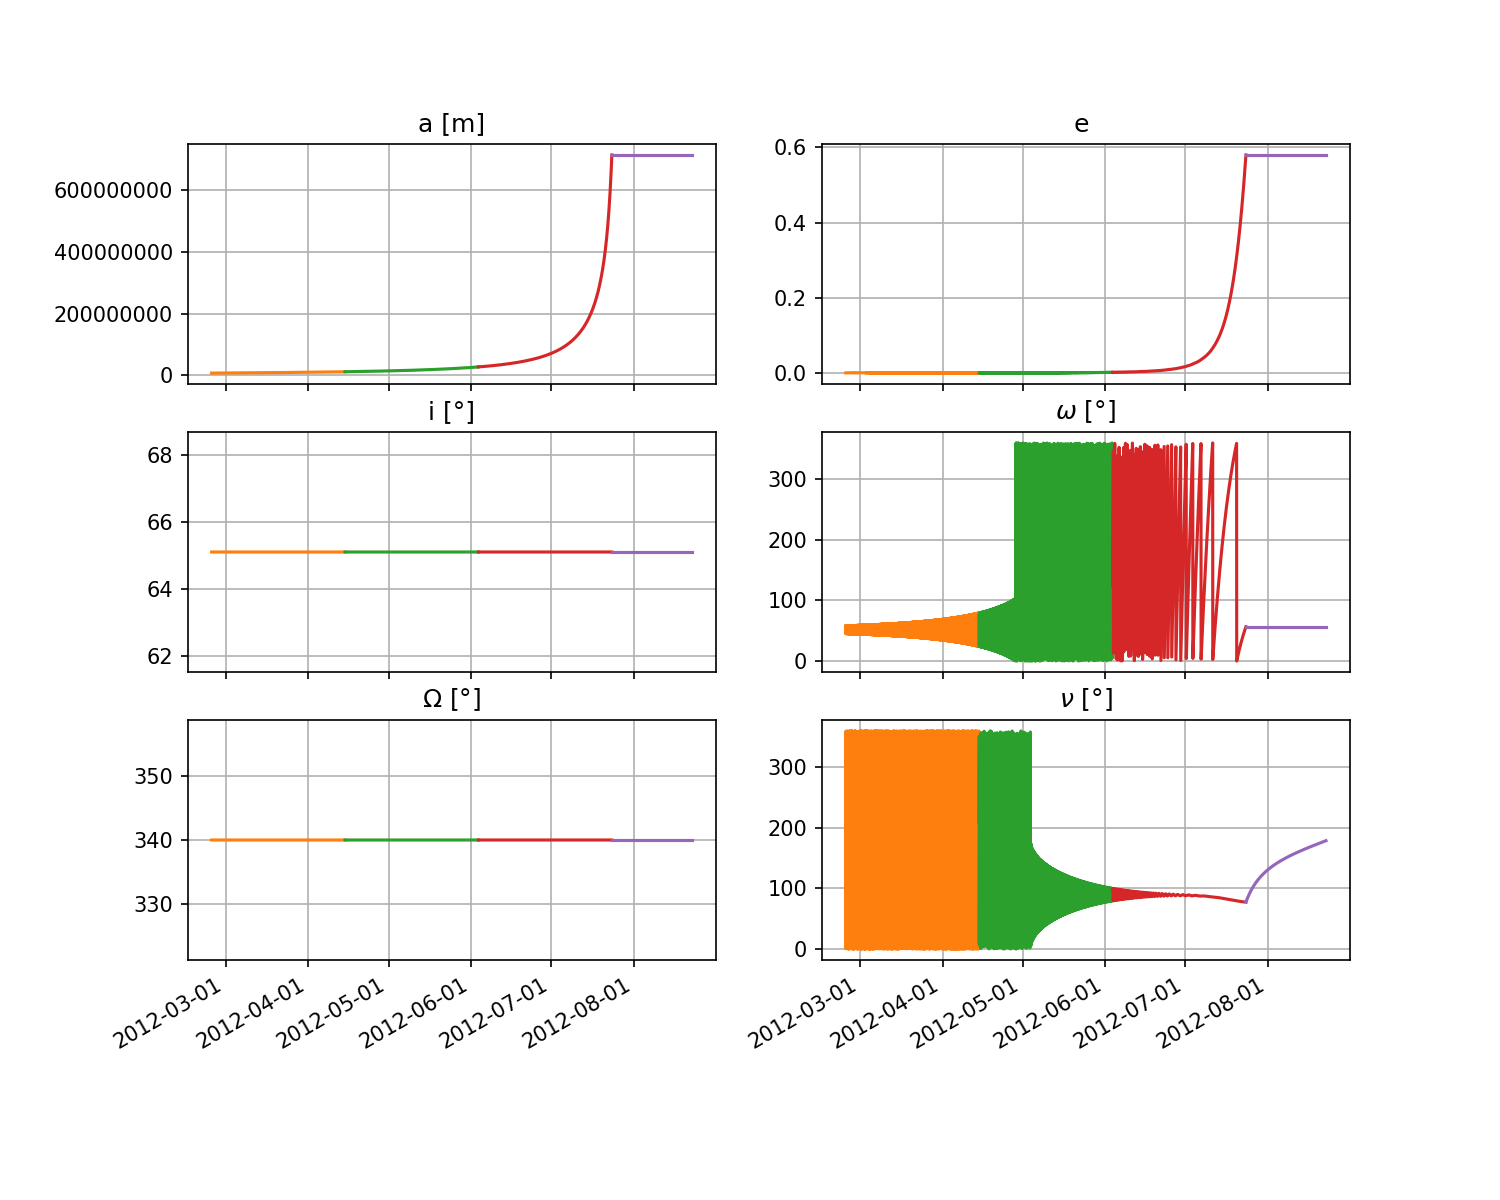

<IPython.core.display.Javascript object>


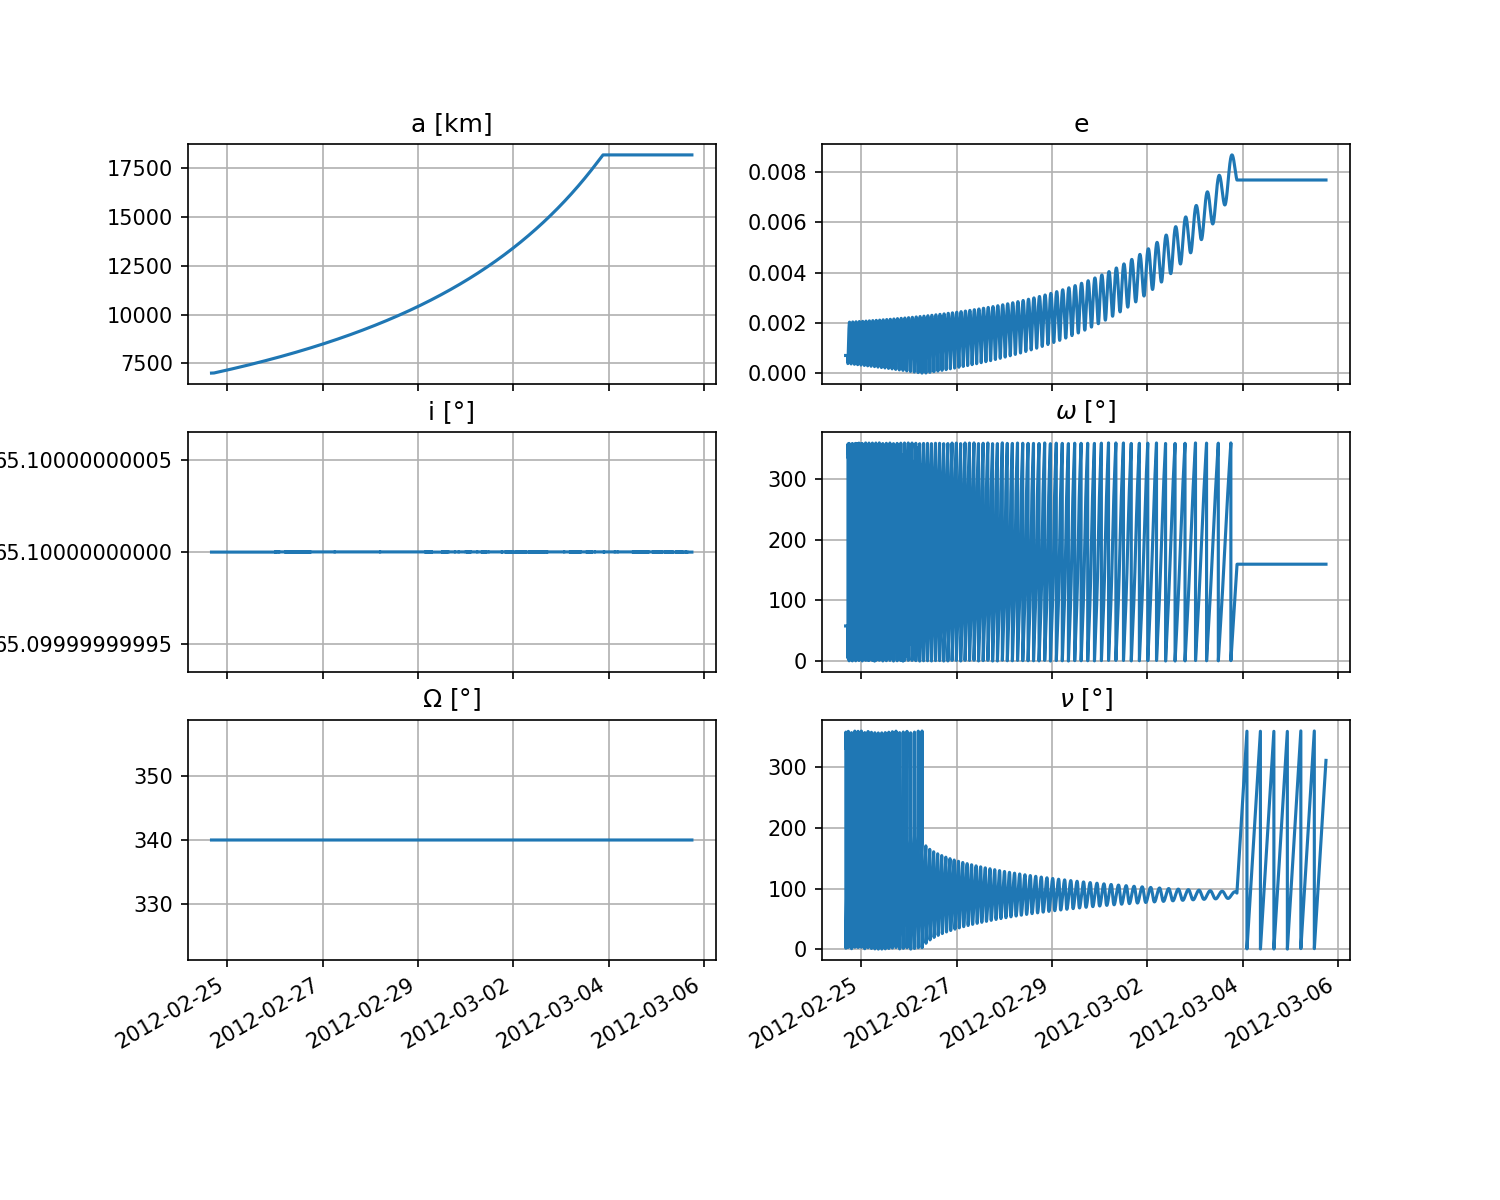

<IPython.core.display.Javascript object>


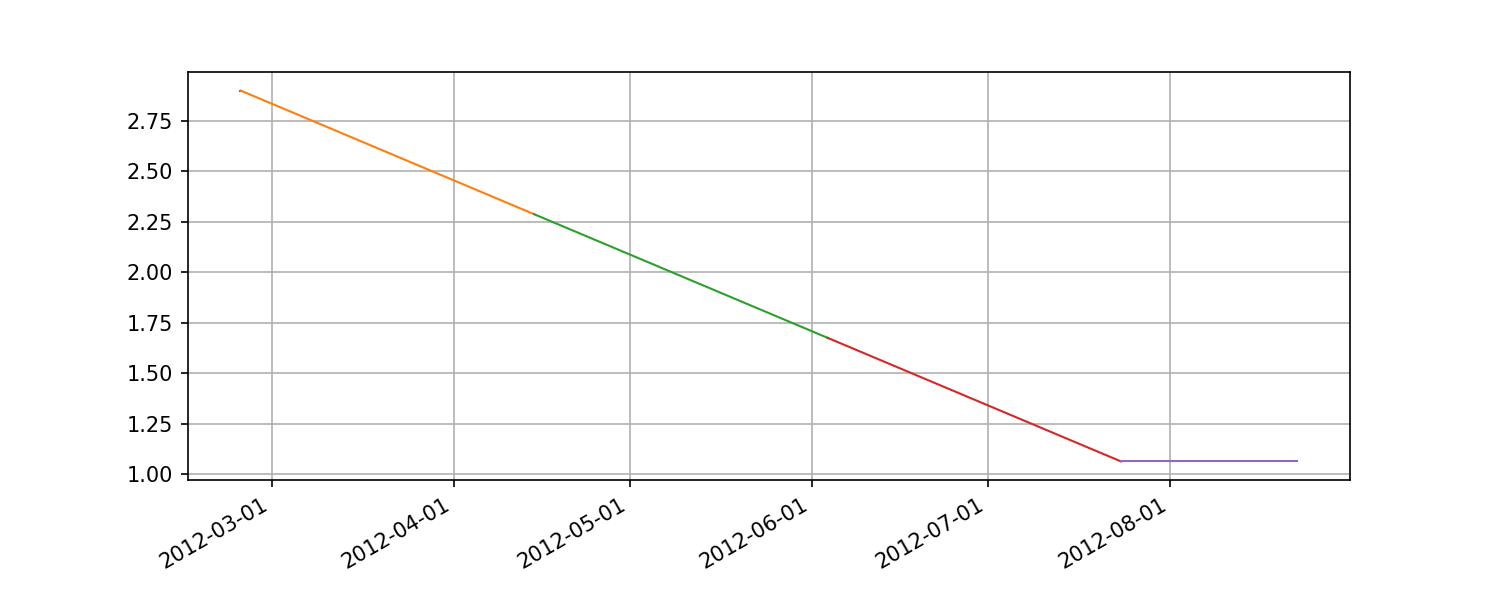

<IPython.core.display.Javascript object>


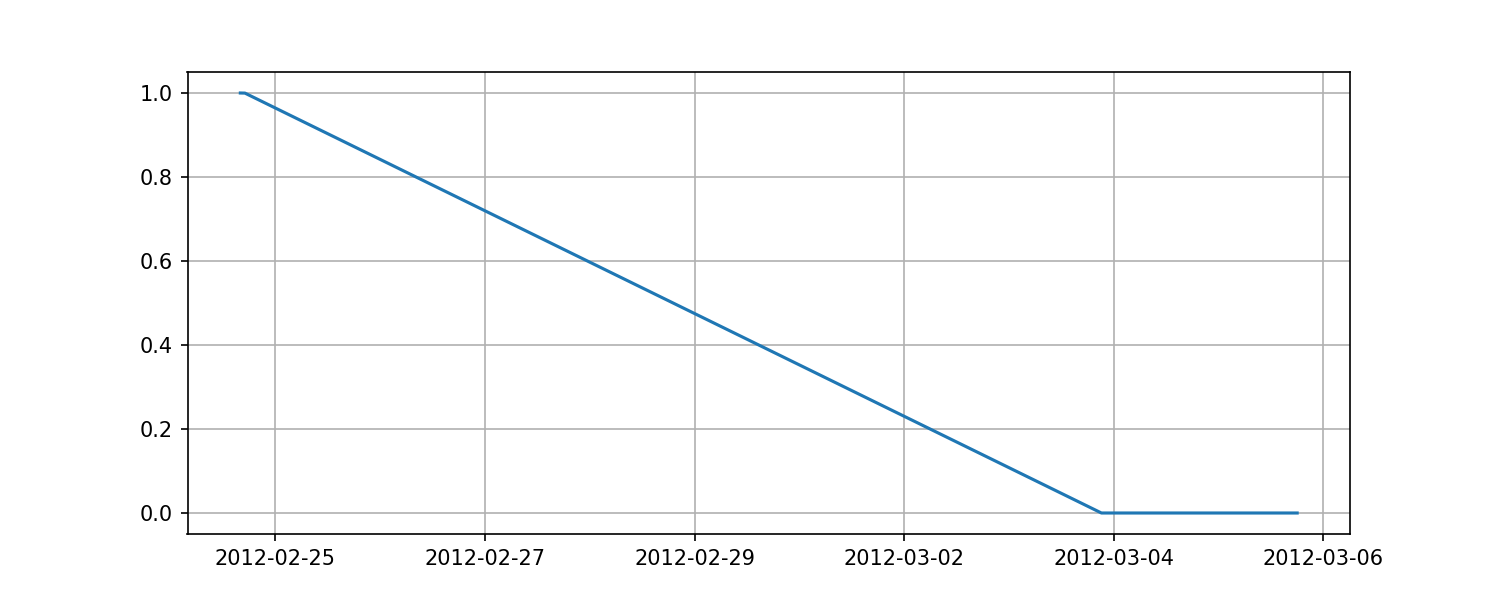

In [121]:
%config InlineBackend.figure_format = 'retina'
maneuver.plot("coe");
# PLOTTING CLASSICAL ORBITAL ELEMENTS
titles = ["a","e","i","$\omega$","$\Omega$","$\\nu$"]
ylabels = ["[km]", "", "[°]", "[°]", "[°]", "[°]"]
dictKeys = ["Semimajor_Axis","Eccentricity","Inclination","Argument_of_Periapsis","RAAN","True_Anomaly"]
fig, axes = plt.subplots(3,2,figsize=(10,8))
for i in range(0,6):
    if i in [2,3,4,5]:
        axes[int((i-i%2)/2),i%2].plot(data["Time"],data[dictKeys[i]])
    else:
        axes[int((i-i%2)/2),i%2].plot(data["Time"],data[dictKeys[i]])
    axes[int((i-i%2)/2),i%2].set_title(titles[i]+" "+ylabels[i])
    
    fig.autofmt_xdate()
    axes[int((i-i%2)/2),i%2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_scientific(False)
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_useOffset(False)
    axes[int((i-i%2)/2),i%2].grid(b=True)
maneuver.plot("singleItem",maneuver.history.propMass)
plt.figure(figsize=(10,4))
plt.plot(data["Time"],data["FuelMass"])
plt.grid()